In [51]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import StepLR
import itertools

In [52]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


In [ ]:
class Nuclear_Norm():
    '''
    Class to perform the optimization for calculating the minimum nuclear norm decomposition of a tensor

    Parameters:
    -----------
    nature: str : nature of the tensor (symmetric or unsymmetric)
    dim: tuple : dimensions of the tensor
    device: torch.device : device to perform the optimization
    type: str : type of the tensor (real or complex)
    form: str : form of the input tensor (as a tensor or as a density matrix)

    Methods:
    --------
    is_symmetric_tensor: Check if the tensor is symmetric
    Parameter_Init: Initialize the parameters for the optimization
    Reconstructed_State: Reconstruct the tensor from the parameters to get T' using einsum
    Norm_Cost: Calculate the cost of the nuclear norm of the tensor. Minimum value of this cost is the nuclear norm of the tensor
    Product_State_Cost: Calculate the cost of the product state of the tensor. This cost prevents the product state from being zero
    Reconstruction_Cost: Calculate the cost of the reconstruction of the tensor. This cost is the mean squared error between the original tensor and the reconstructed tensor
    Coefficent_Loss: Calculate the cost of the coefficents of the tensor. This is a L2 regularization term to make the coefficents sparse
    Nuclear_Rank: Calculate the nuclear rank of the tensor. This is the number of non-zero coefficents in the tensor
    forward: Calculate the total loss of the optimization
    '''

    def __init__(self, nature, dim, device, type, form):
        '''
        Initialize the parameters for the optimization

        Parameters:
        -----------
        nature: str : nature of the tensor (symmetric or unsymmetric)
        dim: tuple : dimensions of the tensor
        device: torch.device : device to perform the optimization
        type: str : type of the tensor (real or complex)
        form: str : form of the input tensor (as a tensor or as a density matrix)

        Initializes:
        ------------
        order: int : order of the tensor
        dim_total: int : total dimnsionality of the tensor
        r_max: int : maximum rank of the tensor

        Returns:
        --------
        None
        '''

        self.nature = nature
        # Check if the nature string is valid
        if self.nature not in ["symmetric", "unsymmetric"]:
            raise ValueError("Invalid nature string. Choose symmetric or unsymmetric")
        
        self.dim = dim
        self.order = np.size(dim)
        self.device = device
        self.type = type
        # Check if the type string is valid
        if self.type not in ["real", "complex"]:
            raise ValueError("Invalid type string. Choose real or complex")
        
        self.form = form
        # Check if the form string is valid
        if self.form not in ["tensor", "density_matrix"]:
            raise ValueError("Invalid form string. Choose tensor or density_matrix")
        
        self.dim_total = np.prod(self.dim)

        if self.form == "tensor":
            self.r_max = int(self.dim_total/np.max(self.dim))
        elif self.form == "density_matrix":
            self.r_max = int(self.dim_total/np.max(self.dim))**2


    def is_symmetric_tensor(self, T):
        '''
        Check if the tensor is symmetric

        Parameters:
        -----------
        T: torch.tensor : tensor to check for symmetry

        Returns:
        --------
        None: Raises an error if the tensor is not symmetric
        '''

        for i in range(self.order):
            for j in range(i+1, self.order):
                if self.dim[i] != self.dim[j]:
                    raise ValueError("Input tensor is not symmetric as the dimensions are not equal")

        indices = list(range(self.order))
        for perm in itertools.permutations(indices):
            if not torch.allclose(T, T.permute(perm)):
                raise ValueError("Input tensor is not symmetric as it is not invariant under permutation of indices")
            

    def Parameter_Init(self):
        '''
        Initialize the parameters for the optimization

        Parameters:
        -----------
        None

        Returns:
        --------
        Param_dict: dict : dictionary of the parameters for the optimization
        '''

        Param_dict = {}

        if self.form == "tensor":
            if self.type == "real":
                Param_dict["K"] = torch.randn(self.r_max, requires_grad=True, device=self.device)

            elif self.type == "complex":
                Param_dict["K"] = torch.randn((self.r_max, 2), requires_grad=True, device=self.device)

            if self.type == "real":
                if self.nature == "unsymmetric":        
                    for i in range(self.order):
                        Param_dict["x"+str(i+1)] = torch.randn((self.dim[i], self.r_max), requires_grad=True, device=self.device)

                elif self.nature == "symmetric":
                    Param_dict["x"] = torch.randn((self.dim[0], self.r_max), requires_grad=True, device=self.device)

            elif self.type == "complex":
                if self.nature == "unsymmetric":
                    for i in range(self.order):
                        Param_dict["x"+str(i+1)] = torch.randn((self.dim[i], self.r_max, 2), requires_grad=True, device=self.device)

                elif self.nature == "symmetric":
                    Param_dict["x"] = torch.randn((self.dim[0], self.r_max, 2), requires_grad=True, device=self.device)

        elif self.form == "density_matrix":
            if self.type == "real":
                Param_dict["K"] = torch.randn(self.r_max, requires_grad=True, device=self.device)
                for i in range(self.order):
                    Param_dict["x"+str(i+1)] = torch.randn((self.dim[i], self.r_max), requires_grad=True, device=self.device) # Ket initialization
                    Param_dict["y"+str(i+1)] = torch.randn((self.dim[i], self.r_max), requires_grad=True, device=self.device) # Bra initialization

            elif self.type == "complex":
                Param_dict["K"] = torch.randn(self.r_max, requires_grad=True, device=self.device)
                for i in range(self.order):
                    Param_dict["x"+str(i+1)] = torch.randn((self.dim[i], self.r_max, 2), requires_grad=True, device=self.device)
                    Param_dict["y"+str(i+1)] = torch.randn((self.dim[i], self.r_max, 2), requires_grad=True, device=self.device)                

        return Param_dict



    def Reconstructed_State(self, Param_dict):
        '''
        Reconstruct the tensor from the parameters to get T' using einsum. Depending on the form of the input tensor, the reconstructed tensor is returned as either a tensor or a density matrix.
        
        Parameters:
        -----------
        Param_dict: dict : dictionary of the parameters for the optimization

        Returns:
        --------
        T_recon: torch.tensor : reconstructed tensor T'
        '''
        
        if self.form == "tensor":
            if self.type == "real":
                T_recon = torch.zeros(self.dim, dtype=torch.float32, device=self.device)
                
                if self.nature == "unsymmetric":
                    for r in range(self.r_max):
                        phi = torch.einsum('i,j->ij', Param_dict["x1"][:, r], Param_dict["x2"][:, r])
                        for i in range(2, self.order):
                            phi = torch.einsum('...ij, k->...ijk', phi, Param_dict["x"+str(i+1)][:, r])
                        T_recon = T_recon + Param_dict["K"][r]*phi

                elif self.nature == "symmetric":
                    for r in range(self.r_max):
                        phi = torch.einsum('i,j->ij', Param_dict["x"][:, r], Param_dict["x"][:, r])
                        for i in range(2, self.order):
                            phi = torch.einsum('...ij, k->...ijk', phi, Param_dict["x"][:, r])
                        T_recon = T_recon + Param_dict["K"][r]*phi

            elif self.type == "complex":
                T_recon = torch.zeros(self.dim, dtype=torch.complex64, device=self.device)

                if self.nature == "unsymmetric":
                    for r in range(self.r_max):
                        phi = torch.einsum('i,j->ij', Param_dict["x1"][:, r, 0] + 1j*Param_dict["x1"][:, r, 1], Param_dict["x2"][:, r, 0] + 1j*Param_dict["x2"][:, r, 1])
                        for i in range(2, self.order):
                            phi = torch.einsum('...ij, k->...ijk', phi, Param_dict["x"+str(i+1)][:, r, 0] + 1j*Param_dict["x"+str(i+1)][:, r, 1])
                        T_recon = T_recon + (Param_dict["K"][r, 0] + 1j*Param_dict["K"][r, 1])*phi

                elif self.nature == "symmetric":
                    for r in range(self.r_max):
                        phi = torch.einsum('i,j->ij', Param_dict["x"][:, r, 0] + 1j*Param_dict["x"][:, r, 1], Param_dict["x"][:, r, 0] + 1j*Param_dict["x"][:, r, 1])
                        for i in range(2, self.order):
                            phi = torch.einsum('...ij, k->...ijk', phi, Param_dict["x"][:, r, 0] + 1j*Param_dict["x"][:, r, 1])
                        T_recon = T_recon + (Param_dict["K"][r, 0] + 1j*Param_dict["K"][r, 1])*phi

        elif self.form == "density_matrix":
            if self.type == "real":
                T_recon = torch.zeros((self.dim_total, self.dim_total), dtype=torch.float32, device=self.device)

                for r in range(self.r_max):
                    phi_x = torch.einsum('i,j->ij', Param_dict["x1"][:, r], Param_dict["x2"][:, r])
                    phi_y = torch.einsum('i,j->ij', Param_dict["y1"][:, r], Param_dict["y2"][:, r])
                    for i in range(2, self.order):
                        phi_x = torch.einsum('...ij, k->...ijk', phi_x, Param_dict["x"+str(i+1)][:, r])
                        phi_y = torch.einsum('...ij, k->...ijk', phi_y, Param_dict["y"+str(i+1)][:, r])
                    phi_x_flat = phi_x.view(-1, 1)
                    phi_y_flat = phi_y.view(-1, 1)
                    rho = phi_x_flat @ phi_y_flat.T
                    T_recon = T_recon + Param_dict["K"][r]*rho

            elif self.type == "complex":
                T_recon = torch.zeros((self.dim_total, self.dim_total), dtype=torch.complex64, device=self.device)

                for r in range(self.r_max):
                    phi_x = torch.einsum('i,j->ij', Param_dict["x1"][:, r, 0] + 1j*Param_dict["x1"][:, r, 1], Param_dict["x2"][:, r, 0] + 1j*Param_dict["x2"][:, r, 1])
                    phi_y = torch.einsum('i,j->ij', Param_dict["y1"][:, r, 0] + 1j*Param_dict["y1"][:, r, 1], Param_dict["y2"][:, r, 0] + 1j*Param_dict["y2"][:, r, 1])
                    for i in range(2, self.order):
                        phi_x = torch.einsum('...ij, k->...ijk', phi_x, Param_dict["x"+str(i+1)][:, r, 0] + 1j*Param_dict["x"+str(i+1)][:, r, 1])
                        phi_y = torch.einsum('...ij, k->...ijk', phi_y, Param_dict["y"+str(i+1)][:, r, 0] + 1j*Param_dict["y"+str(i+1)][:, r, 1])
                    phi_x_flat = phi_x.view(-1, 1)
                    phi_y_flat = phi_y.view(-1, 1)
                    rho = phi_x_flat @ phi_y_flat.T.conj()
                    T_recon = T_recon + Param_dict["K"][r]*rho
        
        return T_recon
    


    def Norm_Cost(self, Param_dict):
        '''
        Calculate the cost of the nuclear norm of the tensor. Minimum value of this cost is the nuclear norm of the tensor

        Parameters:
        -----------
        Param_dict: dict : dictionary of the parameters for the optimization

        Returns:
        --------
        norm: torch.tensor : nuclear norm of the tensor
        '''

        norm = 0

        if self.form == "tensor":
            if self.type == "real":
                if self.nature == "unsymmetric":
                    for r in range(self.r_max):
                        product_state_norm = 1
                        for i in range(self.order):
                            product_state_norm = product_state_norm * torch.norm(Param_dict["x"+str(i+1)][:, r])
                        norm = norm + torch.abs(Param_dict["K"][r])*product_state_norm

                elif self.nature == "symmetric":
                    for r in range(self.r_max):
                        product_state_norm = torch.norm(Param_dict["x"][:, r])**self.order
                        norm = norm + torch.abs(Param_dict["K"][r])*product_state_norm

            elif self.type == "complex":
                if self.nature == "unsymmetric":
                    for r in range(self.r_max):
                        product_state_norm = 1
                        for i in range(self.order):
                            product_state_norm = product_state_norm * torch.norm(Param_dict["x"+str(i+1)][:, r, 0] + 1j*Param_dict["x"+str(i+1)][:, r, 1])
                        norm = norm + torch.norm(Param_dict["K"][r, 0] + 1j*Param_dict["K"][r, 1])*product_state_norm

                elif self.nature == "symmetric":
                    for r in range(self.r_max):
                        product_state_norm = torch.norm(Param_dict["x"][:, r, 0] + 1j*Param_dict["x"][:, r, 1])**self.order
                        norm = norm + torch.norm(Param_dict["K"][r, 0] + 1j*Param_dict["K"][r, 1])*product_state_norm

        elif self.form == "density_matrix":
            if self.type == "real":
                for r in range(self.r_max):
                    phi_x = torch.einsum('i,j->ij', Param_dict["x1"][:, r], Param_dict["x2"][:, r])
                    phi_y = torch.einsum('i,j->ij', Param_dict["y1"][:, r], Param_dict["y2"][:, r])
                    for i in range(2, self.order):
                        phi_x = torch.einsum('...ij, k->...ijk', phi_x, Param_dict["x"+str(i+1)][:, r])
                        phi_y = torch.einsum('...ij, k->...ijk', phi_y, Param_dict["y"+str(i+1)][:, r])
                    phi_x_flat = phi_x.view(-1, 1)
                    phi_y_flat = phi_y.view(-1, 1)
                    rho = phi_x_flat @ phi_y_flat.T
                    norm = norm + torch.abs(Param_dict["K"][r])*torch.norm(rho, p='fro')

            elif self.type == "complex":
                for r in range(self.r_max):
                    phi_x = torch.einsum('i,j->ij', Param_dict["x1"][:, r, 0] + 1j*Param_dict["x1"][:, r, 1], Param_dict["x2"][:, r, 0] + 1j*Param_dict["x2"][:, r, 1])
                    phi_y = torch.einsum('i,j->ij', Param_dict["y1"][:, r, 0] + 1j*Param_dict["y1"][:, r, 1], Param_dict["y2"][:, r, 0] + 1j*Param_dict["y2"][:, r, 1])
                    for i in range(2, self.order):
                        phi_x = torch.einsum('...ij, k->...ijk', phi_x, Param_dict["x"+str(i+1)][:, r, 0] + 1j*Param_dict["x"+str(i+1)][:, r, 1])
                        phi_y = torch.einsum('...ij, k->...ijk', phi_y, Param_dict["y"+str(i+1)][:, r, 0] + 1j*Param_dict["y"+str(i+1)][:, r, 1])
                    phi_x_flat = phi_x.view(-1, 1)
                    phi_y_flat = phi_y.view(-1, 1)
                    rho = phi_x_flat @ phi_y_flat.T.conj()
                    norm = norm + torch.abs(Param_dict["K"][r])*torch.norm(rho, p='fro')
                        
            norm = torch.sqrt(norm)
        return norm
    


    def Product_State_Cost(self, Param_dict, eps=1e-6):
        '''
        Calculate the cost of the product state of the tensor. This cost prevents the product state from being zero

        Parameters:
        -----------
        Param_dict: dict : dictionary of the parameters for the optimization
        eps: float : small value to prevent log(0) error (default = 1e-6)

        Returns:
        --------
        product_state_cost: torch.tensor : cost of the product state of the tensor
        '''

        product_state_cost = 0

        if self.form == "tensor":
            if self.type == "real":
                if self.nature == "unsymmetric":
                    for r in range(self.r_max):
                        for i in range(self.order):
                            product_state_cost = product_state_cost + torch.abs(torch.log(torch.norm(Param_dict["x"+str(i+1)][:, r]) + eps))

                elif self.nature == "symmetric":
                    for r in range(self.r_max):
                        product_state_cost = product_state_cost + torch.abs(torch.log(torch.norm(Param_dict["x"][:, r]) + eps)) * self.order

            elif self.type == "complex":
                if self.nature == "unsymmetric":
                    for r in range(self.r_max):
                        for i in range(self.order):
                            product_state_cost = product_state_cost + torch.abs(torch.log(torch.norm(Param_dict["x"+str(i+1)][:, r, 0] + 1j*Param_dict["x"+str(i+1)][:, r, 1]) + eps))

                elif self.nature == "symmetric":
                    for r in range(self.r_max):
                        product_state_cost = product_state_cost + torch.abs(torch.log(torch.norm(Param_dict["x"][:, r, 0] + 1j*Param_dict["x"][:, r, 1]) + eps)) * self.order

        elif self.form == "density_matrix":
            if self.type == "real":
                for r in range(self.r_max):
                    for i in range(self.order):
                        bra_cost = torch.abs(torch.log(torch.norm(Param_dict["x"+str(i+1)][:, r]) + eps))
                        ket_cost = torch.abs(torch.log(torch.norm(Param_dict["y"+str(i+1)][:, r]) + eps))
                        product_state_cost = product_state_cost + bra_cost + ket_cost

            elif self.type == "complex":
                for r in range(self.r_max):
                    for i in range(self.order):
                        bra_cost = torch.abs(torch.log(torch.norm(Param_dict["x"+str(i+1)][:, r, 0] + 1j*Param_dict["x"+str(i+1)][:, r, 1]) + eps))
                        ket_cost = torch.abs(torch.log(torch.norm(Param_dict["y"+str(i+1)][:, r, 0] + 1j*Param_dict["y"+str(i+1)][:, r, 1]) + eps))
                        product_state_cost = product_state_cost + bra_cost + ket_cost

        return product_state_cost
    


    def Reconstruction_Cost(self, T, T_recon):
        '''
        Calculate the cost of the reconstruction of the tensor. This cost is the mean squared error between the original tensor and the reconstructed tensor

        Parameters:
        -----------
        T: torch.tensor : original tensor T
        T_recon: torch.tensor : reconstructed tensor T'

        Returns:
        --------
        loss: torch.tensor : mean squared error between the original tensor and the reconstructed tensor (||T - T'||^2)
        '''
        
        if self.type == "real":
            return F.mse_loss(T, T_recon)
        elif self.type == "complex":
            return F.mse_loss(T.real, T_recon.real) + F.mse_loss(T.imag, T_recon.imag)


    def Coefficent_Loss(self, Param_dict):
        '''
        Calculate the cost of the coefficents of the tensor. This is a L2 regularization term to make the coefficents sparse

        Parameters:
        -----------
        Param_dict: dict : dictionary of the parameters for the optimization

        Returns:
        --------
        torch.tensor : L2 regularization term of the coefficents (||K||^2)
        '''
        if self.type == "real" or self.form == "density_matrix":
            return torch.norm(Param_dict["K"])
        elif self.type == "complex" and self.form == "tensor":
            return torch.sqrt(torch.norm(Param_dict["K"][:, 0])**2 + torch.norm(Param_dict["K"][:, 1])**2)



    def Nuclear_Rank(self, Param_dict, threshold = 1e-2):
        '''
        Calculate the nuclear rank of the tensor. This is the number of non-zero coefficents in the tensor

        Parameters:
        -----------
        Param_dict: dict : dictionary of the parameters for the optimization
        threshold: float : threshold to consider a coefficent as non-zero (default = 1e-2)

        Returns:
        --------
        non_zero_weights: int : number of non-zero coefficents in the tensor
        '''

        non_zero_weights = 0
        if self.type == "real" or self.form == "density_matrix":
            non_zero_weights = torch.sum(torch.abs(Param_dict["K"]) > threshold)

        elif self.type == "complex" and self.form == "tensor":
            non_zero_weights = torch.sum(torch.sqrt(Param_dict["K"][:, 0]**2 + Param_dict["K"][:, 1]**2) > threshold)

        return non_zero_weights

  
    
    def forward(self, T, params):
        '''
        Calculate the total loss of the optimization
        
        Parameters:
        -----------
        T: torch.tensor : original tensor T
        params: dict : dictionary of the parameters for the optimization
        
        Returns:
        --------
        loss: torch.tensor : total loss of the optimization
        '''

        k_1 = 1e7 * self.dim_total # Reconstruction Cost Coefficent
        k_2 = 10 * self.order # Coefficent Cost Coefficent
        k_3 = 100 * self.dim_total # Product State Cost Coefficent
        k_4 = 1e3 * self.dim_total # Norm Cost Coefficent
        
        # params = self.Parameter_Init()
        T_recon = self.Reconstructed_State(params)
        coeff_loss = self.Coefficent_Loss(params)
        recon_loss = self.Reconstruction_Cost(T, T_recon)
        product_state_loss = self.Product_State_Cost(params)
        norm_loss = self.Norm_Cost(params)

        loss = k_1*recon_loss + k_2*coeff_loss + k_3*product_state_loss + k_4*norm_loss

        return loss

In [54]:
def InputState(dim, type, form, device):

    d_type = torch.float32
    
    if type == "complex":
        d_type = torch.complex64
    A = torch.zeros(dim, dtype=d_type)

    #### Customize the input state here ####
    
    if form == "density_matrix":
        A = A.view(np.prod(dim), 1) @ A.view(1, np.prod(dim)).conj()
    
    # W state has position 1, 2, 4 making 9 combinations

    # A[0, 0, 0] = 1/np.sqrt(2)
    # A[1, 1, 1] = 1/np.sqrt(2)
    # A[0, 0] = 1/2
    # A[0, 1] = 1/2
    # A[1, 0] = 1/2
    # A[1, 1] = 1/2


    A[1, 1] = 1/3
    A[1, 2] = 1/3
    A[1, 4] = 1/3
    A[2, 1] = 1/3
    A[2, 2] = 1/3
    A[2, 4] = 1/3
    A[4, 1] = 1/3
    A[4, 2] = 1/3
    A[4, 4] = 1/3

    # A[0, 0 ,1] = 1/np.sqrt(3)
    # A[0, 1, 0] = 1/np.sqrt(3)
    # A[1, 0, 0] = 1/np.sqrt(3)

    # psi_p = torch.zeros(dim, dtype=d_type)
    # psi_p[0, 0] = 1/np.sqrt(3)
    # psi_p[1, 1] = 1/np.sqrt(3)
    # psi_p[2, 2] = 1/np.sqrt(3)

    # rho_1 = psi_p.view(-1, 1) @ psi_p.view(1, -1).conj()

    # sigma_p = torch.zeros((np.prod(dim), np.prod(dim)), dtype=d_type)
    # sigma_p[1, 1] = 1/3
    # sigma_p[5, 5] = 1/3
    # sigma_p[6, 6] = 1/3

    # sigma_m = torch.zeros((np.prod(dim), np.prod(dim)), dtype=d_type)
    # sigma_m[3, 3] = 1/3
    # sigma_m[7, 7] = 1/3
    # sigma_m[2, 2] = 1/3

    # alpha = 3.5

    # A = (2/7 * rho_1) + (alpha/7 * sigma_p) + ((5 - alpha)/7 * sigma_m)

    # psi_1 = torch.zeros(dim, dtype=d_type)
    # psi_1[0, 0] = 1/2
    # psi_1[1, 1] = 1/2
    # psi_1[2, 2] = 1/np.sqrt(2)

    # rho_1 = psi_1.view(-1, 1) @ psi_1.view(1, -1).conj()

    # psi_2 = torch.zeros(dim, dtype=d_type)
    # psi_2[0, 1] = 1/2
    # psi_2[1, 0] = 1/2
    # psi_2[3, 3] = 1/np.sqrt(2)

    # rho_2 = psi_2.view(-1, 1) @ psi_2.view(1, -1).conj()

    # sigma = torch.zeros((np.prod(dim), np.prod(dim)), dtype=d_type)
    # sigma[2, 2] = 1/8
    # sigma[3, 3] = 1/8
    # sigma[6, 6] = 1/8
    # sigma[7, 7] = 1/8
    # sigma[8, 8] = 1/8
    # sigma[9, 9] = 1/8
    # sigma[12, 12] = 1/8
    # sigma[13, 13] = 1/8

    # alpha = 2*np.sqrt(2)

    # A = 1/(2 + alpha) * (rho_1 + rho_2 + alpha * sigma)
    ########################################
    return A.to(device)

In [ ]:
type = "complex"
nature = "symmetric"
# dim = (4,4)
dim = (2,2,2)
form = "density_matrix"

T = InputState(dim, type, form, device)

nuclear_norm = Nuclear_Norm(nature, dim, device, type, form)

Param_dict = nuclear_norm.Parameter_Init()

if nature == "symmetric" and form == "tensor":
    nuclear_norm.is_symmetric_tensor(T)

learning_rate = 0.01
optimizer = torch.optim.Adam(Param_dict.values(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=12500, gamma=0.5)

In [56]:
Loss = []
N_Norm = []

EPOCHS = 30000

In [57]:
for epoch in tqdm(range(EPOCHS)):
    optimizer.zero_grad()
    loss = nuclear_norm.forward(T, Param_dict)
    loss.backward()
    Loss.append(loss.item())
    N_Norm.append(nuclear_norm.Norm_Cost(Param_dict).item())

    optimizer.step()

    if scheduler.get_last_lr()[0] > 1e-6:
        scheduler.step()

    if epoch % 100 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Reconstruction loss: {nuclear_norm.Reconstruction_Cost(T, nuclear_norm.Reconstructed_State(Param_dict)).item()}, Nuclear Norm: {nuclear_norm.Norm_Cost(Param_dict).item()}, learning rate: {scheduler.get_last_lr()}")

  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 0, Loss: 82073247744.0, Reconstruction loss: 896.9765014648438, Nuclear Norm: 26.497310638427734, learning rate: [0.01]
Epoch 100, Loss: 177921104.0, Reconstruction loss: 2.1796164512634277, Nuclear Norm: 16.048547744750977, learning rate: [0.01]
Epoch 200, Loss: 44472336.0, Reconstruction loss: 0.5481520295143127, Nuclear Norm: 15.625338554382324, learning rate: [0.01]
Epoch 300, Loss: 19945640.0, Reconstruction loss: 0.24562202394008636, Nuclear Norm: 15.417848587036133, learning rate: [0.01]
Epoch 400, Loss: 11636468.0, Reconstruction loss: 0.142684668302536, Nuclear Norm: 15.280473709106445, learning rate: [0.01]
Epoch 500, Loss: 7750152.5, Reconstruction loss: 0.0944322794675827, Nuclear Norm: 15.18291187286377, learning rate: [0.01]
Epoch 600, Loss: 5582259.5, Reconstruction loss: 0.06748108565807343, Nuclear Norm: 15.109652519226074, learning rate: [0.01]
Epoch 700, Loss: 4235882.0, Reconstruction loss: 0.05072982609272003, Nuclear Norm: 15.052358627319336, learning rate: 

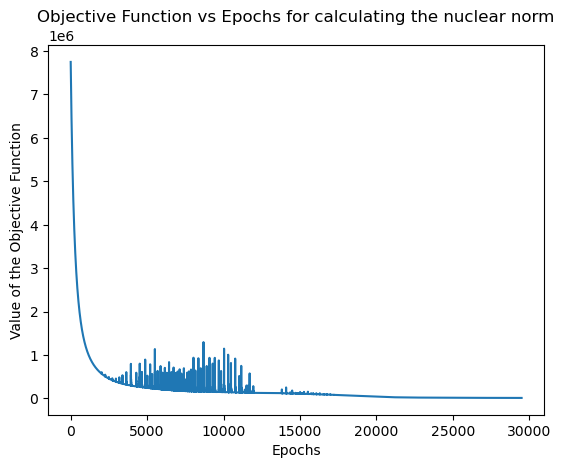

In [58]:
plt.plot(Loss[500:])
plt.xlabel("Epochs")
plt.ylabel("Value of the Objective Function")
plt.title("Objective Function vs Epochs for calculating the nuclear norm")
plt.show()

In [59]:
print("Input State: \n", np.round(T.cpu().detach().numpy(), 3))
print("\nReconstructed State: \n", np.round(nuclear_norm.Reconstructed_State(Param_dict).cpu().detach().numpy(), 3))
print("\nCoefficients: \n", Param_dict["K"].cpu().detach().numpy())
# print("\nTensor state: \n", Param_dict["x"][:, 1].cpu().detach().numpy())
# print("\nTensor state: \n", Param_dict["x1"][:, 1].cpu().detach().numpy())

Input State: 
 [[0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.333+0.j 0.333+0.j 0.   +0.j 0.333+0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.333+0.j 0.333+0.j 0.   +0.j 0.333+0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.333+0.j 0.333+0.j 0.   +0.j 0.333+0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]]

Reconstructed State: 
 [[-0.001+0.j     0.   -0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j   ]
 [-0.   +0.j     0.332+0.j     0.332-0.j    -0.   +0.j     0.332+0.j
  -0.   +0.j    -0.   -0.j     0.   -0.j   ]
 [-0.   -0.j     0.332+0.j     0.332+0.j    -0.   -0

In [60]:
# analytical_rank = 4
analytical_rank = 1
# nuclear_rank = Nuclear_Rank(Param_dict, type)
nuclear_rank = nuclear_norm.Nuclear_Rank(Param_dict)

print(f"Analytical Rank: {analytical_rank}")
print(f"Nuclear Rank: {nuclear_rank}")

Analytical Rank: 1
Nuclear Rank: 9


In [61]:
analytical_nuclear_norm = 1.5
# analytical_nuclear_norm = np.sqrt(3)
final_nuclear_norm = N_Norm[-1]

# print(f"Analytical Nuclear Norm: {analytical_nuclear_norm}")
print(f"Calculated Nuclear Norm: {final_nuclear_norm}")

Calculated Nuclear Norm: 1.5263173580169678


In [62]:
alpha = 2

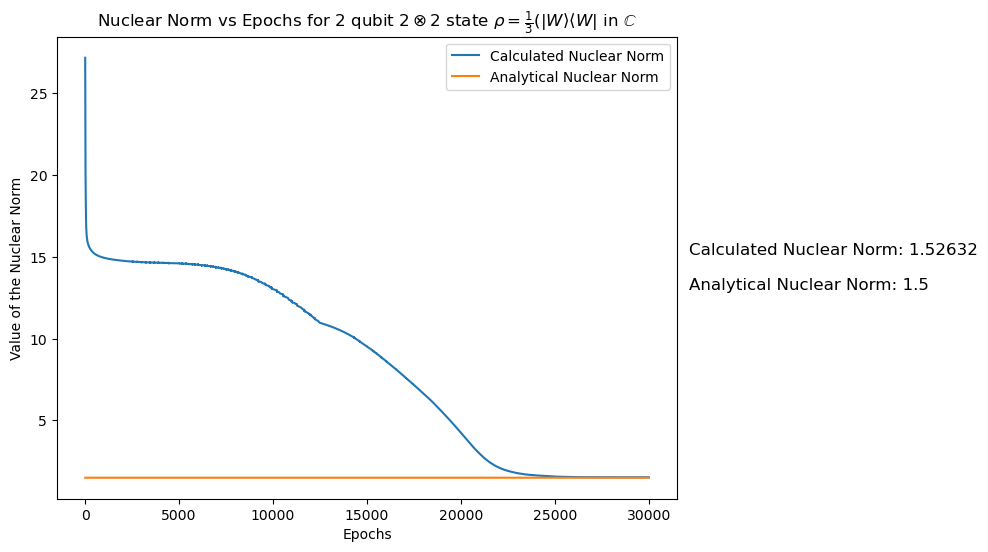

In [64]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

ax.plot(N_Norm, label="Calculated Nuclear Norm")
ax.plot([analytical_nuclear_norm]*EPOCHS, label="Analytical Nuclear Norm")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.text(1.02, 0.5, 
        f'Calculated Nuclear Norm: {round(N_Norm[-1], 5)}\n\nAnalytical Nuclear Norm: {analytical_nuclear_norm}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='center')

# ax.text(1.02, 0.5, 
#         f'Calculated Nuclear Norm: {round(N_Norm[-1], 5)}', 
#         transform=ax.transAxes, fontsize=12, verticalalignment='center')

ax.set_xlabel("Epochs")
ax.set_ylabel("Value of the Nuclear Norm")
ax.set_title(r"Nuclear Norm vs Epochs for 2 qubit $2\otimes 2$ state $\rho = \frac{1}{3}(|W\rangle\langle W|$ in $\mathbb{C}$")
# ax.set_title(r"Nuclear Norm vs Epochs for 2 qubit $3\otimes 3$ mixed state $\rho = \frac{2}{7}|\psi_+\rangle\langle \psi_+| + \frac{\alpha}{7}.\sigma_+ + \frac{5 - \alpha}{7}.\sigma_-$ in $\mathbb{C}$ for $\alpha$ = %s" % alpha)
# ax.set_title(r"Nuclear Norm vs Epochs for 2 qubit $4\otimes 4$ mixed state $\rho = \frac{1}{2 + \alpha}(|\psi_1\rangle\langle \psi_1| + |\psi_2\rangle\langle \psi_2|+ \alpha.\sigma)$ in $\mathbb{C}$ for $\alpha = 2\sqrt{2}$")

ax.legend()
plt.show()